## „Éá„Éº„Çø„Çª„ÉÉ„Éà„ÅÆÊ∫ñÂÇô

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
warnings.filterwarnings('ignore')

In [2]:
def space_clean(row):
    """Á©∫ÁôΩÊñáÂ≠ó„ÇíÊï¥ÁêÜ"""
    row = row.replace(". ", "").replace(" .", "").replace("  ", " ")
    return row

def canonicalize(smiles):
    """SMILES„ÇíÊ≠£Ë¶èÂåñ"""
    try:
        new_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        new_smiles = None
    return new_smiles

In [3]:
# „Éá„Éº„ÇøË™≠„ÅøËæº„Åø
df = pd.read_csv("../data/Buchwald-Hartwig/Dreher_and_Doyle_reaction_t5_ready.csv")
print(f"„Éá„Éº„ÇøÊï∞: {len(df)}")
df.head()

„Éá„Éº„ÇøÊï∞: 1980


REACTANT  \
0  BrC1=CC=C(C(F)(F)F)C=C1.Cc1ccc(N)cc1   
1        BrC1=CC=C(CC)C=C1.Cc1ccc(N)cc1   
2        BrC1=CC=C(OC)C=C1.Cc1ccc(N)cc1   
3            BrC1=CN=CC=C1.Cc1ccc(N)cc1   
4            BrC1=NC=CC=C1.Cc1ccc(N)cc1   

                                            REAGENT  \
0  CC(C)(C)/N=C(N(C)C)/N(C)C.C1(C2=CC=CC=C2)=CC=NO1   
1  CC(C)(C)/N=C(N(C)C)/N(C)C.C1(C2=CC=CC=C2)=CC=NO1   
2  CC(C)(C)/N=C(N(C)C)/N(C)C.C1(C2=CC=CC=C2)=CC=NO1   
3  CC(C)(C)/N=C(N(C)C)/N(C)C.C1(C2=CC=CC=C2)=CC=NO1   
4  CC(C)(C)/N=C(N(C)C)/N(C)C.C1(C2=CC=CC=C2)=CC=NO1   

                                            CATALYST  SOLVENT  \
0  O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F...      NaN   
1  O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F...      NaN   
2  O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F...      NaN   
3  O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F...      NaN   
4  O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F...      NaN   

                          PRODUCT      YIELD  
0  Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1  30.591262  
1        CCc1ccc(Nc2ccc(C)cc2)cc1  18.869009  
2        COc1ccc(Nc2ccc(C)cc2)cc1   3.867386  
3            Cc1ccc(Nc2cccnc2)cc1  11.383346  
4            Cc1ccc(Nc2ccccn2)cc1  48.487494

In [4]:
# ÂøÖÈ†à„Ç´„É©„É†„ÅÆÂ≠òÂú®„ÉÅ„Çß„ÉÉ„ÇØ„Å®Ë£úÂÆå
required_cols = ["REACTANT", "CATALYST", "REAGENT", "SOLVENT", "PRODUCT"]
for col in required_cols:
    if col not in df.columns:
        df[col] = ""

# YIELD„ÇíÊ®ôÊ∫ñÂåñÔºà0-1„Å´Ê≠£Ë¶èÂåñÔºâ
if "YIELD" in df.columns:
    df["YIELD"] = df["YIELD"].clip(0, 100) / 100

In [5]:
# SMILESÊ≠£Ë¶èÂåñ„Å®‰∏çÊ≠£„Éá„Éº„ÇøÈô§Âéª
for col in ["REAGENT", "REACTANT", "PRODUCT"]:
    df[col] = df[col].apply(space_clean)
    df[col] = df[col].apply(lambda x: canonicalize(x) if x != " " else " ")
    df = df[~df[col].isna()].reset_index(drop=True)
    df[col] = df[col].apply(lambda x: ".".join(sorted(x.split("."))))

In [6]:
# CATALYST„ÄÅREAGENT„ÇíÁµ±Âêà
df["REAGENT"] = df["CATALYST"].fillna(" ") + "." + df["REAGENT"].fillna(" ")
print(f"ÂâçÂá¶ÁêÜÂæå„ÅÆ„Éá„Éº„ÇøÊï∞: {len(df)}")

ÂâçÂá¶ÁêÜÂæå„ÅÆ„Éá„Éº„ÇøÊï∞: 1980


## Morgan Fingerprint„ÅÆË®àÁÆó

In [7]:
def smiles_to_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """
    SMILES„Åã„ÇâMorgan Fingerprint„ÇíË®àÁÆó
    
    Args:
        smiles: SMILESÊñáÂ≠óÂàó
        radius: Morgan Fingerprint„ÅÆÂçäÂæÑÔºà„Éá„Éï„Ç©„É´„Éà: 2Ôºâ
        n_bits: „Éì„ÉÉ„ÉàÊï∞Ôºà„Éá„Éï„Ç©„É´„Éà: 2048Ôºâ
    
    Returns:
        numpy array: „Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÅÆ„Éì„ÉÉ„Éà„Éô„ÇØ„Éà„É´
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(n_bits)
        fp = rdFingerprintGenerator.GetMorganGenerator(mol, radius, n_bits)
        return np.array(fp)
    except:
        return np.zeros(n_bits)

def reaction_to_fingerprint(reactant, reagent, product, radius=2, n_bits=2048):
    """
    ÂèçÂøúÁâ©„ÄÅË©¶Ëñ¨„ÄÅÁîüÊàêÁâ©„Åã„ÇâMorgan Fingerprint„ÇíÁµêÂêà
    
    Args:
        reactant: ÂèçÂøúÁâ©„ÅÆSMILES
        reagent: Ë©¶Ëñ¨„ÅÆSMILES
        product: ÁîüÊàêÁâ©„ÅÆSMILES
        radius: Morgan Fingerprint„ÅÆÂçäÂæÑ
        n_bits: ÂêÑÂàÜÂ≠ê„ÅÆ„Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÅÆ„Éì„ÉÉ„ÉàÊï∞
    
    Returns:
        numpy array: ÁµêÂêà„Åï„Çå„Åü„Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà
    """
    fp_reactant = smiles_to_morgan_fingerprint(reactant, radius, n_bits)
    fp_reagent = smiles_to_morgan_fingerprint(reagent, radius, n_bits)
    fp_product = smiles_to_morgan_fingerprint(product, radius, n_bits)
    
    # 3„Å§„ÅÆ„Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÇíÁµêÂêà
    return np.concatenate([fp_reactant, fp_reagent, fp_product])

In [8]:
# ÂÖ®„Éá„Éº„Çø„ÅÆ„Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÇíË®àÁÆó
print("Morgan Fingerprint„ÇíË®àÁÆó‰∏≠...")
fingerprints = []
for idx, row in df.iterrows():
    fp = reaction_to_fingerprint(row["REACTANT"], row["REAGENT"], row["PRODUCT"])
    fingerprints.append(fp)
    if (idx + 1) % 100 == 0:
        print(f"  {idx + 1}/{len(df)} ÂÆå‰∫Ü")

X = np.array(fingerprints)
y = df["YIELD"].values * 100  # „Éë„Éº„Çª„É≥„ÉàË°®Ë®ò„Å´Êàª„Åô

print(f"\n„Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÅÆÂΩ¢Áä∂: {X.shape}")
print(f"ÂèéÁéá„ÅÆÁØÑÂõ≤: {y.min():.2f}% - {y.max():.2f}%")

Morgan Fingerprint„ÇíË®àÁÆó‰∏≠...
  100/1980 ÂÆå‰∫Ü
  200/1980 ÂÆå‰∫Ü
  300/1980 ÂÆå‰∫Ü
  400/1980 ÂÆå‰∫Ü
  500/1980 ÂÆå‰∫Ü
  600/1980 ÂÆå‰∫Ü
  700/1980 ÂÆå‰∫Ü
  800/1980 ÂÆå‰∫Ü
  900/1980 ÂÆå‰∫Ü
  1000/1980 ÂÆå‰∫Ü
  1100/1980 ÂÆå‰∫Ü
  1200/1980 ÂÆå‰∫Ü
  1300/1980 ÂÆå‰∫Ü
  1400/1980 ÂÆå‰∫Ü
  1500/1980 ÂÆå‰∫Ü
  1600/1980 ÂÆå‰∫Ü
  1700/1980 ÂÆå‰∫Ü
  1800/1980 ÂÆå‰∫Ü
  1900/1980 ÂÆå‰∫Ü

„Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÅÆÂΩ¢Áä∂: (1980, 6144)
ÂèéÁéá„ÅÆÁØÑÂõ≤: 0.00% - 99.03%


## „Ç¨„Ç¶„ÇπÈÅéÁ®ãÂõûÂ∏∞„É¢„Éá„É´„ÅÆÊßãÁØâ

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
import csv

In [10]:
def create_reaction_dictionaries(df):
    """
    „Éá„Éº„Çø„Çª„ÉÉ„Éà„Åã„ÇâÂèçÂøúËæûÊõ∏„Çí‰ΩúÊàê
    
    Returns:
        tuple: (reactant_list, reagent_list, product_list, product_dict, true_yield_dict, fingerprint_dict)
    """
    reactant_list = sorted(df["REACTANT"].unique())
    reagent_list = sorted(df["REAGENT"].unique())
    product_list = sorted(df["PRODUCT"].unique())
    
    # (reactant, reagent) -> product „ÅÆ„Éû„ÉÉ„Éî„É≥„Ç∞
    product_dict = {
        (row["REACTANT"], row["REAGENT"]): row["PRODUCT"]
        for _, row in df.iterrows()
    }
    
    # (reactant, reagent, product) -> yield „ÅÆ„Éû„ÉÉ„Éî„É≥„Ç∞
    true_yield_dict = {
        (row["REACTANT"], row["REAGENT"], row["PRODUCT"]): row["YIELD"] * 100
        for _, row in df.iterrows()
    }
    
    # (reactant, reagent, product) -> fingerprint „ÅÆ„Éû„ÉÉ„Éî„É≥„Ç∞
    fingerprint_dict = {}
    for idx, row in df.iterrows():
        key = (row["REACTANT"], row["REAGENT"], row["PRODUCT"])
        fingerprint_dict[key] = X[idx]
    
    print(f"ReactantÂÄôË£úÊï∞: {len(reactant_list)}")
    print(f"ReagentÂÄôË£úÊï∞: {len(reagent_list)}")
    print(f"ProductÂÄôË£úÊï∞: {len(product_list)}")
    print(f"Êó¢Áü•„ÅÆÁµÑ„ÅøÂêà„Çè„ÅõÊï∞: {len(product_dict)}")
    
    return reactant_list, reagent_list, product_list, product_dict, true_yield_dict, fingerprint_dict

In [11]:
# ËæûÊõ∏„ÅÆ‰ΩúÊàê
reactant_list, reagent_list, product_list, product_dict, true_yield_dict, fingerprint_dict = create_reaction_dictionaries(df)

ReactantÂÄôË£úÊï∞: 15
ReagentÂÄôË£úÊï∞: 132
ProductÂÄôË£úÊï∞: 5
Êó¢Áü•„ÅÆÁµÑ„ÅøÂêà„Çè„ÅõÊï∞: 1980


## „Éô„Ç§„Ç∫ÊúÄÈÅ©Âåñ„ÅÆÂÆüË£Ö

In [12]:
class GaussianProcessBayesianOptimization:
    """
    „Ç¨„Ç¶„ÇπÈÅéÁ®ãÂõûÂ∏∞„Çí‰ΩøÁî®„Åó„Åü„Éô„Ç§„Ç∫ÊúÄÈÅ©Âåñ
    Morgan Fingerprint„ÇíÁâπÂæ¥Èáè„Å®„Åó„Å¶‰ΩøÁî®
    """
    
    def __init__(self, reactant_list, reagent_list, product_dict, true_yield_dict, fingerprint_dict, output_dir="../runs/gpr_yield_NiB"):
        """
        Args:
            reactant_list: reactant„ÅÆÂÄôË£ú„É™„Çπ„Éà
            reagent_list: reagent„ÅÆÂÄôË£ú„É™„Çπ„Éà
            product_dict: (reactant, reagent) -> product „ÅÆ„Éû„ÉÉ„Éî„É≥„Ç∞ËæûÊõ∏
            true_yield_dict: (reactant, reagent, product) -> yield „ÅÆ„Éû„ÉÉ„Éî„É≥„Ç∞ËæûÊõ∏
            fingerprint_dict: (reactant, reagent, product) -> fingerprint „ÅÆ„Éû„ÉÉ„Éî„É≥„Ç∞ËæûÊõ∏
            output_dir: Âá∫Âäõ„Éá„Ç£„É¨„ÇØ„Éà„É™
        """
        self.reactant_list = reactant_list
        self.reagent_list = reagent_list
        self.product_dict = product_dict
        self.true_yield_dict = true_yield_dict
        self.fingerprint_dict = fingerprint_dict
        self.output_dir = output_dir
        
        # ÂÖ®„Å¶„ÅÆÊúâÂäπ„Å™ÁµÑ„ÅøÂêà„Çè„Åõ„Çí‰∫ãÂâçË®àÁÆó
        self.valid_combinations = []
        for reactant in reactant_list:
            for reagent in reagent_list:
                if (reactant, reagent) in product_dict:
                    self.valid_combinations.append((reactant, reagent))
        
        print(f"ÊúâÂäπ„Å™ÁµÑ„ÅøÂêà„Çè„ÅõÊï∞: {len(self.valid_combinations)}")
        
        # „Ç¨„Ç¶„ÇπÈÅéÁ®ãÂõûÂ∏∞„É¢„Éá„É´„ÅÆÂàùÊúüÂåñ
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1.0)
        self.gp_model = GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=10,
            normalize_y=True,
            alpha=1e-6
        )
        
        # ÂÆüÈ®ìÁµêÊûú„ÅÆË®òÈå≤
        self.experiment_history = []
        self.tried_combinations = set()
        self.X_train = []  # Â≠¶ÁøíÁî®„Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà
        self.y_train = []  # Â≠¶ÁøíÁî®ÂèéÁéá
        
        # Âá∫Âäõ„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅÆ‰ΩúÊàê
        os.makedirs(output_dir, exist_ok=True)
        self.log_csv_path = os.path.join(output_dir, "optimization_log.csv")
        self._init_csv_log()
    
    def _init_csv_log(self):
        """CSV„É≠„Ç∞„Éï„Ç°„Ç§„É´„ÅÆÂàùÊúüÂåñ"""
        if not os.path.exists(self.log_csv_path):
            with open(self.log_csv_path, "w", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "trial", "reactant", "reagent", "product",
                    "predicted_mean", "predicted_std", "actual_yield",
                    "error_pct", "acquisition_value"
                ])
    
    def _log_experiment_to_csv(self, experiment_result):
        """ÂÆüÈ®ìÁµêÊûú„ÇíCSV„Å´Ë®òÈå≤"""
        with open(self.log_csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow([
                experiment_result['trial'],
                experiment_result['reactant'],
                experiment_result['reagent'],
                experiment_result['product'],
                f"{experiment_result['predicted_mean']:.6f}",
                f"{experiment_result['predicted_std']:.6f}",
                f"{experiment_result['actual_yield']:.6f}",
                f"{experiment_result['error_pct']:+.6f}",
                f"{experiment_result['acquisition_value']:.6f}"
            ])
    
    def _predict_yield_with_uncertainty(self, fingerprints):
        """
        „Ç¨„Ç¶„ÇπÈÅéÁ®ãÂõûÂ∏∞„Å´„Çà„Çã‰∫àÊ∏¨„Å®‰∏çÁ¢∫ÂÆüÊÄß„ÅÆÊé®ÂÆö
        
        Args:
            fingerprints: „Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÅÆÈÖçÂàó (n_samples, n_features)
        
        Returns:
            tuple: (‰∫àÊ∏¨Âπ≥Âùá, ‰∫àÊ∏¨Ê®ôÊ∫ñÂÅèÂ∑Æ)
        """
        if len(self.X_train) == 0:
            # ÂàùÊúüÁä∂ÊÖã„Åß„ÅØ„É©„É≥„ÉÄ„É†„Å™‰∫àÊ∏¨
            n_samples = fingerprints.shape[0] if len(fingerprints.shape) > 1 else 1
            return np.ones(n_samples) * 50.0, np.ones(n_samples) * 30.0
        
        mean, std = self.gp_model.predict(fingerprints, return_std=True)
        return mean, std
    
    def _acquisition_function(self, mean, std, best_observed_yield, xi=0.01):
        """
        ÊúüÂæÖÊîπÂñÑÈáèÔºàExpected ImprovementÔºâ„Å´„Çà„ÇãÁç≤ÂæóÈñ¢Êï∞
        
        Args:
            mean: ‰∫àÊ∏¨Âπ≥Âùá
            std: ‰∫àÊ∏¨Ê®ôÊ∫ñÂÅèÂ∑Æ
            best_observed_yield: „Åì„Çå„Åæ„Åß„ÅÆÊúÄËâØÂèéÁéá
            xi: Êé¢Á¥¢„Å®Ê¥ªÁî®„ÅÆ„Éà„É¨„Éº„Éâ„Ç™„Éï„Éë„É©„É°„Éº„Çø
        
        Returns:
            ÊúüÂæÖÊîπÂñÑÈáè
        """
        if isinstance(std, np.ndarray):
            std = np.maximum(std, 1e-9)  # Êï∞ÂÄ§ÂÆâÂÆöÊÄß„ÅÆ„Åü„ÇÅ
        else:
            std = max(std, 1e-9)
        
        z = (mean - best_observed_yield - xi) / std
        ei = (mean - best_observed_yield - xi) * norm.cdf(z) + std * norm.pdf(z)
        return ei
    
    def _get_best_observed_yield(self):
        """„Åì„Çå„Åæ„Åß„ÅÆÊúÄËâØÂèéÁéá„ÇíÂèñÂæó"""
        if len(self.experiment_history) > 0:
            return max([exp['actual_yield'] for exp in self.experiment_history])
        else:
            return 0.0
    
    def _select_next_candidate(self):
        """
        Áç≤ÂæóÈñ¢Êï∞„Å´Âü∫„Å•„ÅÑ„Å¶Ê¨°„ÅÆÂÄôË£ú„ÇíÈÅ∏Êäû
        """
        # Êú™Ë©¶Ë°å„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„ÇíÂèñÂæó
        untried_combinations = [
            combo for combo in self.valid_combinations 
            if combo not in self.tried_combinations
        ]
        
        if not untried_combinations:
            print("ÂÖ®„Å¶„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„ÇíË©¶Ë°åÊ∏à„Åø„Åß„Åô„ÄÇ")
            return None
        
        # Áç≤ÂæóÈñ¢Êï∞„ÇíË®àÁÆó
        best_yield = self._get_best_observed_yield()
        
        # „Éï„Ç£„É≥„Ç¨„Éº„Éó„É™„É≥„Éà„ÅÆ„É™„Çπ„Éà„Çí‰ΩúÊàê
        fingerprints = []
        for reactant, reagent in untried_combinations:
            product = self.product_dict[(reactant, reagent)]
            fp = self.fingerprint_dict[(reactant, reagent, product)]
            fingerprints.append(fp)
        
        fingerprints = np.array(fingerprints)
        
        print(f"Áç≤ÂæóÈñ¢Êï∞ÂÄ§„ÇíË®àÁÆó‰∏≠... ({len(untried_combinations)}ÂÄã„ÅÆÂÄôË£ú)")
        
        try:
            # „Éê„ÉÉ„ÉÅ„Åß‰∫àÊ∏¨ÂÆüË°å
            pred_means, pred_stds = self._predict_yield_with_uncertainty(fingerprints)
            
            # Áç≤ÂæóÈñ¢Êï∞ÂÄ§„ÇíË®àÁÆó
            acq_values = self._acquisition_function(pred_means, pred_stds, best_yield)
            
            # ÊúÄÂ§ßÁç≤ÂæóÈñ¢Êï∞ÂÄ§„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
            best_idx = np.argmax(acq_values)
            selected_combo = untried_combinations[best_idx]
            
            print(f"üéØ ÈÅ∏Êäû: {selected_combo} (EI: {acq_values[best_idx]:.4f})")
            
            return selected_combo
            
        except Exception as e:
            print(f"‚ùå „Ç®„É©„Éº: {e}")
            # „Ç®„É©„ÉºÊôÇ„ÅØ„É©„É≥„ÉÄ„É†ÈÅ∏Êäû
            import random
            return random.choice(untried_combinations)
    
    def _evaluate_candidate(self, reactant, reagent, trial_num):
        """ÂÄôË£ú„ÇíË©ï‰æ°ÔºàÂÆüÈ®ì„ÇíÂÆüË°åÔºâ"""
        product = self.product_dict[(reactant, reagent)]
        fp = self.fingerprint_dict[(reactant, reagent, product)]
        
        # „Ç¨„Ç¶„ÇπÈÅéÁ®ãÂõûÂ∏∞„Å´„Çà„Çã‰∫àÊ∏¨
        try:
            pred_mean, pred_std = self._predict_yield_with_uncertainty(fp.reshape(1, -1))
            pred_mean = float(pred_mean[0])
            pred_std = float(pred_std[0])
        except Exception as e:
            print(f"‚ùå ‰∫àÊ∏¨„Ç®„É©„Éº: {e}")
            return None
        
        # ÂÆüÈöõ„ÅÆÂèéÁéá„ÇíÂèñÂæó
        key = (reactant, reagent, product)
        actual_yield = self.true_yield_dict.get(key)
        
        if actual_yield is None:
            print(f"‚ùó ÁúüÂÄ§„Å™„Åó: {reactant} + {reagent} ‚Üí {product}")
            actual_yield = 0.0
        
        # Áç≤ÂæóÈñ¢Êï∞„ÅÆË®àÁÆó
        best_yield = self._get_best_observed_yield()
        acquisition_value = float(self._acquisition_function(pred_mean, pred_std, best_yield))
        
        # Ë™§Â∑Æ„ÅÆË®àÁÆó
        error_pct = pred_mean - actual_yield
        
        # ÂÆüÈ®ìÁµêÊûú„ÇíË®òÈå≤
        experiment_result = {
            'trial': trial_num,
            'reactant': reactant,
            'reagent': reagent,
            'product': product,
            'predicted_mean': pred_mean,
            'predicted_std': pred_std,
            'actual_yield': actual_yield,
            'error_pct': error_pct,
            'acquisition_value': acquisition_value
        }
        
        # Âá∫Âäõ
        print(f"üîé Trial {trial_num}: {reactant} + {reagent} ‚Üí {product}")
        print(f"   üìà ‰∫àÊ∏¨: {pred_mean:.2f}% ¬± {pred_std:.2f}%")
        print(f"   üß™ ÁúüÂÄ§: {actual_yield:.2f}%")
        print(f"   ‚ùó Ë™§Â∑Æ: {error_pct:+.2f}%")
        print(f"   üéØ Áç≤ÂæóÈñ¢Êï∞: {acquisition_value:.4f}")
        
        return experiment_result
    
    def _update_model(self, fingerprint, yield_value):
        """Êñ∞„Åó„ÅÑ„Éá„Éº„Çø„Åß„É¢„Éá„É´„ÇíÊõ¥Êñ∞"""
        self.X_train.append(fingerprint)
        self.y_train.append(yield_value)
        
        # „Ç¨„Ç¶„ÇπÈÅéÁ®ã„É¢„Éá„É´„ÇíÂÜçÂ≠¶Áøí
        X_train_array = np.array(self.X_train)
        y_train_array = np.array(self.y_train)
        
        print(f"   üîÑ „É¢„Éá„É´Êõ¥Êñ∞‰∏≠... (Â≠¶Áøí„Éá„Éº„ÇøÊï∞: {len(self.X_train)})")
        self.gp_model.fit(X_train_array, y_train_array)
    
    def optimize(self, n_trials=50):
        """„Éô„Ç§„Ç∫ÊúÄÈÅ©Âåñ„ÅÆÂÆüË°å"""
        print(f"„Ç¨„Ç¶„ÇπÈÅéÁ®ã„Éô„Ç§„Ç∫ÊúÄÈÅ©Âåñ„ÇíÈñãÂßã ({n_trials}Ë©¶Ë°å)")
        print("="*60)
        
        for trial in range(1, n_trials + 1):
            # Ê¨°„ÅÆÂÄôË£ú„ÇíÈÅ∏Êäû
            candidate = self._select_next_candidate()
            if candidate is None:
                print("ÂÖ®„Å¶„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„ÇíË©¶Ë°åÂÆå‰∫Ü„ÄÇ")
                break
            
            reactant, reagent = candidate
            product = self.product_dict[(reactant, reagent)]
            
            # ÂÄôË£ú„ÇíË©ï‰æ°
            result = self._evaluate_candidate(reactant, reagent, trial)
            if result is None:
                continue
            
            # ÁµêÊûú„ÇíË®òÈå≤
            self.experiment_history.append(result)
            self.tried_combinations.add((reactant, reagent))
            
            # CSV„Å´Ë®òÈå≤
            self._log_experiment_to_csv(result)
            
            # „É¢„Éá„É´„ÇíÊõ¥Êñ∞
            fp = self.fingerprint_dict[(reactant, reagent, product)]
            self._update_model(fp, result['actual_yield'])
            
            # ÈÄ≤ÊçóË°®Á§∫
            current_best = max([exp['actual_yield'] for exp in self.experiment_history])
            print(f"   üí° ÁèæÂú®„ÅÆÊúÄÈ´òÂèéÁéá: {current_best:.2f}%")
            print("-" * 60)
        
        print(f"\nÊúÄÈÅ©ÂåñÂÆå‰∫Ü! Á∑èË©¶Ë°åÊï∞: {len(self.experiment_history)}")
        
        # ÊúÄÁµÇÁµêÊûú
        if self.experiment_history:
            best_exp = max(self.experiment_history, key=lambda x: x['actual_yield'])
            print(f"üèÜ ÊúÄÈ´òÂèéÁéá: {best_exp['actual_yield']:.2f}%")
            print(f"üèÜ ÊúÄÈÅ©ÁµÑ„ÅøÂêà„Çè„Åõ: {best_exp['reactant']} + {best_exp['reagent']} ‚Üí {best_exp['product']}")
            return best_exp
        else:
            return None
    
    def get_optimization_summary(self):
        """ÊúÄÈÅ©Âåñ„ÅÆÊ¶ÇË¶ÅÁµ±Ë®à„ÇíÂèñÂæó"""
        if not self.experiment_history:
            return {}
        
        actual_yields = [exp['actual_yield'] for exp in self.experiment_history]
        predicted_means = [exp['predicted_mean'] for exp in self.experiment_history]
        errors = [exp['error_pct'] for exp in self.experiment_history]
        
        return {
            'total_trials': len(self.experiment_history),
            'max_yield': max(actual_yields),
            'mean_yield': np.mean(actual_yields),
            'std_yield': np.std(actual_yields),
            'mae_error': np.mean(np.abs(errors)),
            'rmse_error': np.sqrt(np.mean(np.array(errors)**2)),
            'coverage': len(self.tried_combinations) / len(self.valid_combinations) * 100,
            'log_path': self.log_csv_path
        }
    
    def save_visualization(self):
        """ÊúÄÈÅ©ÂåñÁµêÊûú„ÇíÂèØË¶ñÂåñ„Åó„Å¶‰øùÂ≠ò"""
        if not self.experiment_history:
            print("ÂÆüÈ®ìÂ±•Ê≠¥„Åå„ÅÇ„Çä„Åæ„Åõ„Çì„ÄÇ")
            return
        
        save_dir = os.path.join(self.output_dir, "visualization")
        os.makedirs(save_dir, exist_ok=True)
        
        trials = [exp['trial'] for exp in self.experiment_history]
        actual_yields = [exp['actual_yield'] for exp in self.experiment_history]
        predicted_means = [exp['predicted_mean'] for exp in self.experiment_history]
        predicted_stds = [exp['predicted_std'] for exp in self.experiment_history]
        errors = [exp['error_pct'] for exp in self.experiment_history]
        
        # Á¥ØÁ©çÊúÄÂ§ßÂÄ§
        cumulative_max = np.maximum.accumulate(actual_yields)
        
        # 1. Optimization Progress
        fig = plt.figure(figsize=(8, 5))
        plt.plot(trials, actual_yields, 'o-', alpha=0.6, label='Actual Yield', markersize=6)
        plt.plot(trials, cumulative_max, 'r-', linewidth=3, label='Best So Far')
        plt.xlabel('Trial')
        plt.ylabel('Yield [%]')
        plt.title('Optimization Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'optimization_progress.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 2. Parity Plot
        fig = plt.figure(figsize=(6, 6))
        plt.scatter(actual_yields, predicted_means, s=50, alpha=0.6)
        lims = [0, 100]
        plt.plot(lims, lims, 'r--', label='Perfect Prediction')
        plt.xlim(lims)
        plt.ylim(lims)
        plt.xlabel('Actual Yield [%]')
        plt.ylabel('Predicted Yield [%]')
        plt.title('Parity Plot')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'parity.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 3. Prediction Uncertainty
        fig = plt.figure(figsize=(8, 5))
        plt.errorbar(trials, predicted_means, yerr=predicted_stds,
                    fmt='o', alpha=0.6, capsize=5, label='Prediction ¬± Uncertainty')
        plt.plot(trials, actual_yields, 'ro', alpha=0.6, label='Actual Yield')
        plt.xlabel('Trial')
        plt.ylabel('Yield [%]')
        plt.title('Prediction Uncertainty')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'uncertainty.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 4. Error Trend
        fig = plt.figure(figsize=(8, 5))
        plt.plot(trials, errors, 'o-', alpha=0.6)
        plt.axhline(0, color='r', linestyle='--', label='Perfect Prediction')
        plt.xlabel('Trial')
        plt.ylabel('Prediction Error [%]')
        plt.title('Prediction Error Trend')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'error_trend.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 5. Error Histogram
        fig = plt.figure(figsize=(7, 5))
        plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(0, color='r', linestyle='--', label='Perfect Prediction')
        plt.xlabel('Prediction Error [%]')
        plt.ylabel('Count')
        plt.title('Error Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'error_hist.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        # 6. Uncertainty vs Actual Yield
        fig = plt.figure(figsize=(7, 5))
        plt.scatter(predicted_stds, actual_yields, alpha=0.6)
        plt.xlabel('Prediction Uncertainty (Std)')
        plt.ylabel('Actual Yield [%]')
        plt.title('Uncertainty vs Actual Yield')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'uncertainty_vs_yield.png'), dpi=180, bbox_inches='tight')
        plt.close(fig)
        
        print(f"ÂèØË¶ñÂåñÂÆå‰∫Ü! ‰øùÂ≠òÂÖà: {save_dir}")

## „Éô„Ç§„Ç∫ÊúÄÈÅ©Âåñ„ÅÆÂÆüË°å

In [13]:
# „Éô„Ç§„Ç∫ÊúÄÈÅ©ÂåñÂô®„ÇíÂàùÊúüÂåñ
gp_optimizer = GaussianProcessBayesianOptimization(
    reactant_list=reactant_list,
    reagent_list=reagent_list,
    product_dict=product_dict,
    true_yield_dict=true_yield_dict,
    fingerprint_dict=fingerprint_dict,
    output_dir="../runs/gpr_100trials_BH"
)

ÊúâÂäπ„Å™ÁµÑ„ÅøÂêà„Çè„ÅõÊï∞: 1980


In [14]:
# „Éô„Ç§„Ç∫ÊúÄÈÅ©Âåñ„ÅÆÂÆüË°å
best_result = gp_optimizer.optimize(n_trials=100)

# ÊúÄÈÅ©Âåñ„ÅÆÊ¶ÇË¶ÅÁµ±Ë®à„ÇíË°®Á§∫
summary = gp_optimizer.get_optimization_summary()
print(f"\n=== ÊúÄÈÅ©ÂåñÊ¶ÇË¶Å ===")
print(f"Á∑èË©¶Ë°åÊï∞: {summary.get('total_trials', 0)}")
print(f"ÊúÄÈ´òÂèéÁéá: {summary.get('max_yield', 0):.2f}%")
print(f"Âπ≥ÂùáÂèéÁéá: {summary.get('mean_yield', 0):.2f}%")
print(f"ÂèéÁéáÊ®ôÊ∫ñÂÅèÂ∑Æ: {summary.get('std_yield', 0):.2f}%")
print(f"‰∫àÊ∏¨Ë™§Â∑Æ (MAE): {summary.get('mae_error', 0):.2f}%")
print(f"‰∫àÊ∏¨Ë™§Â∑Æ (RMSE): {summary.get('rmse_error', 0):.2f}%")
print(f"Êé¢Á¥¢ÁØÑÂõ≤: {summary.get('coverage', 0):.1f}%")
print(f"„É≠„Ç∞„Éï„Ç°„Ç§„É´: {summary.get('log_path', 'N/A')}")

# ÂèØË¶ñÂåñ„Çí‰øùÂ≠ò
gp_optimizer.save_visualization()

„Ç¨„Ç¶„ÇπÈÅéÁ®ã„Éô„Ç§„Ç∫ÊúÄÈÅ©Âåñ„ÇíÈñãÂßã (100Ë©¶Ë°å)
Áç≤ÂæóÈñ¢Êï∞ÂÄ§„ÇíË®àÁÆó‰∏≠... (1980ÂÄã„ÅÆÂÄôË£ú)
üéØ ÈÅ∏Êäû: ('Brc1ccccn1.Cc1ccc(N)cc1', 'O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F)(F)F.CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.CCOC(=O)c1cc(C)no1') (EI: 50.5853)
üîé Trial 1: Brc1ccccn1.Cc1ccc(N)cc1 + O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F)(F)F.CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.CCOC(=O)c1cc(C)no1 ‚Üí Cc1ccc(Nc2ccccn2)cc1
   üìà ‰∫àÊ∏¨: 50.00% ¬± 30.00%
   üß™ ÁúüÂÄ§: 37.65%
   ‚ùó Ë™§Â∑Æ: +12.35%
   üéØ Áç≤ÂæóÈñ¢Êï∞: 50.5853
   üîÑ „É¢„Éá„É´Êõ¥Êñ∞‰∏≠... (Â≠¶Áøí„Éá„Éº„ÇøÊï∞: 1)
   üí° ÁèæÂú®„ÅÆÊúÄÈ´òÂèéÁéá: 37.65%
------------------------------------------------------------
Áç≤ÂæóÈñ¢Êï∞ÂÄ§„ÇíË®àÁÆó‰∏≠... (1979ÂÄã„ÅÆÂÄôË£ú)
üéØ ÈÅ∏Êäû: ('Brc1ccccn1.Cc1ccc(N)cc1', 'O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F)(F)F.CC(C)C(C=C(C(C

## ÂèØË¶ñÂåñ


### Optimization Progress


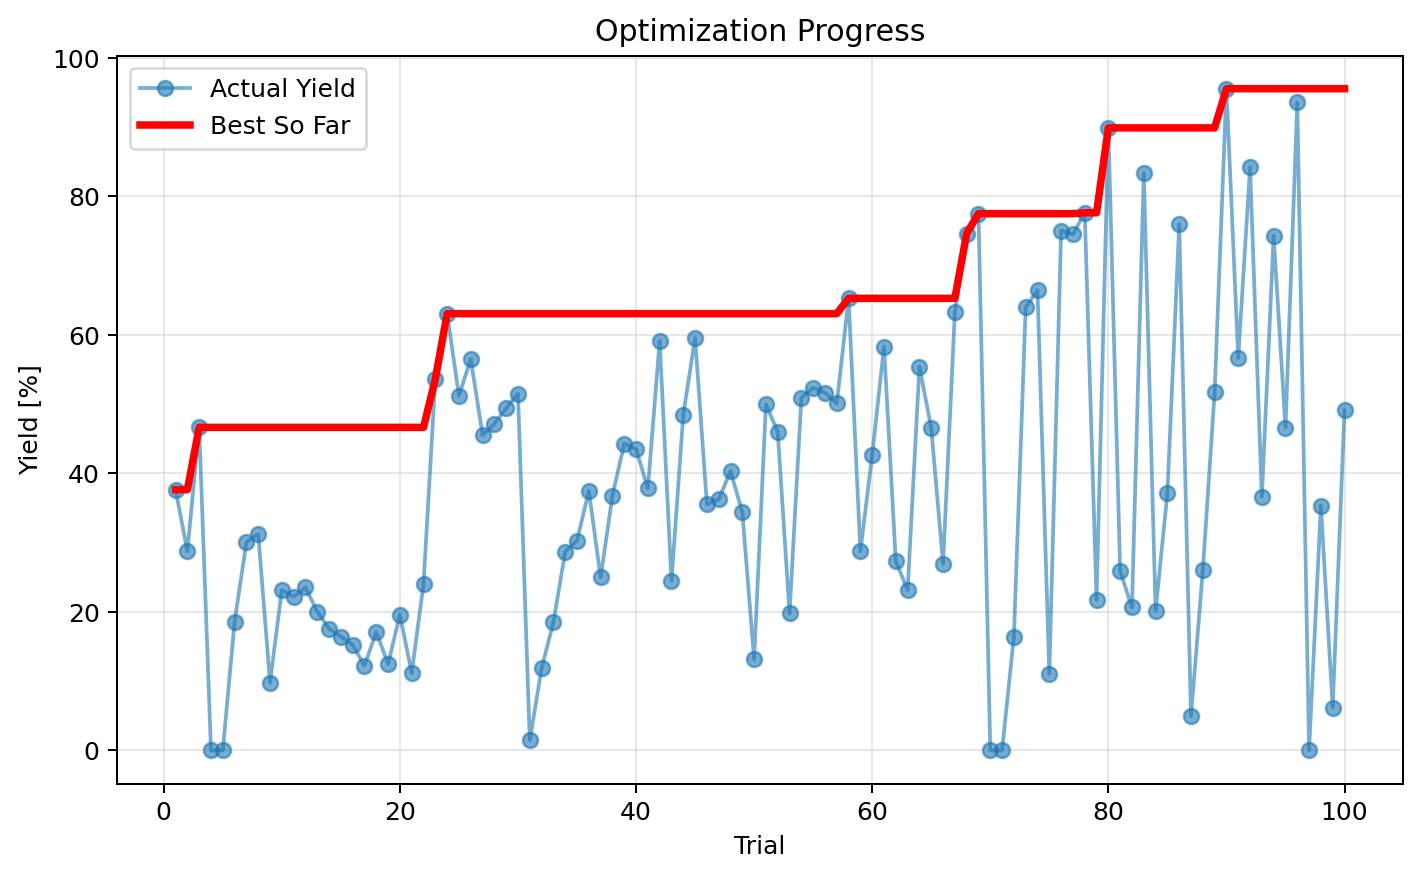


### Parity Plot


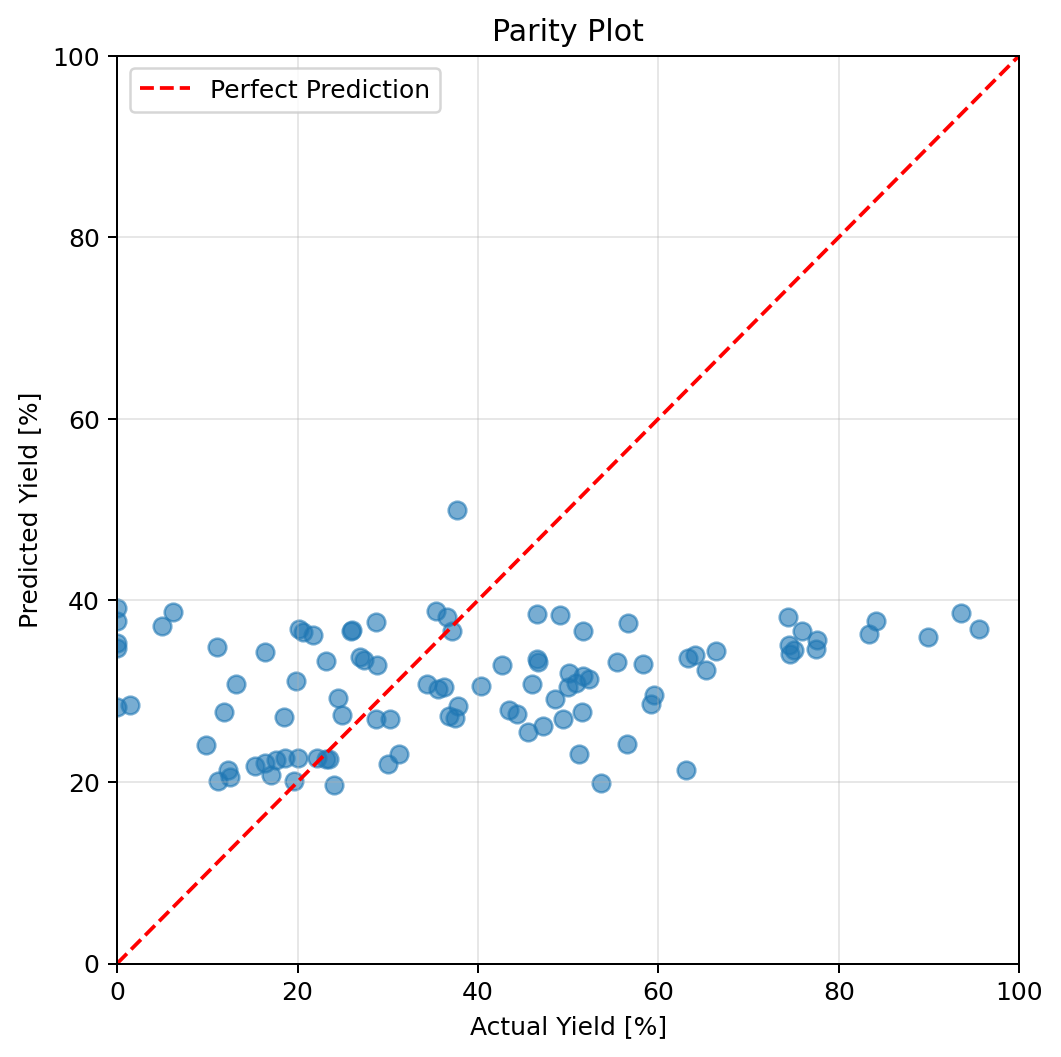


### Prediction Uncertainty


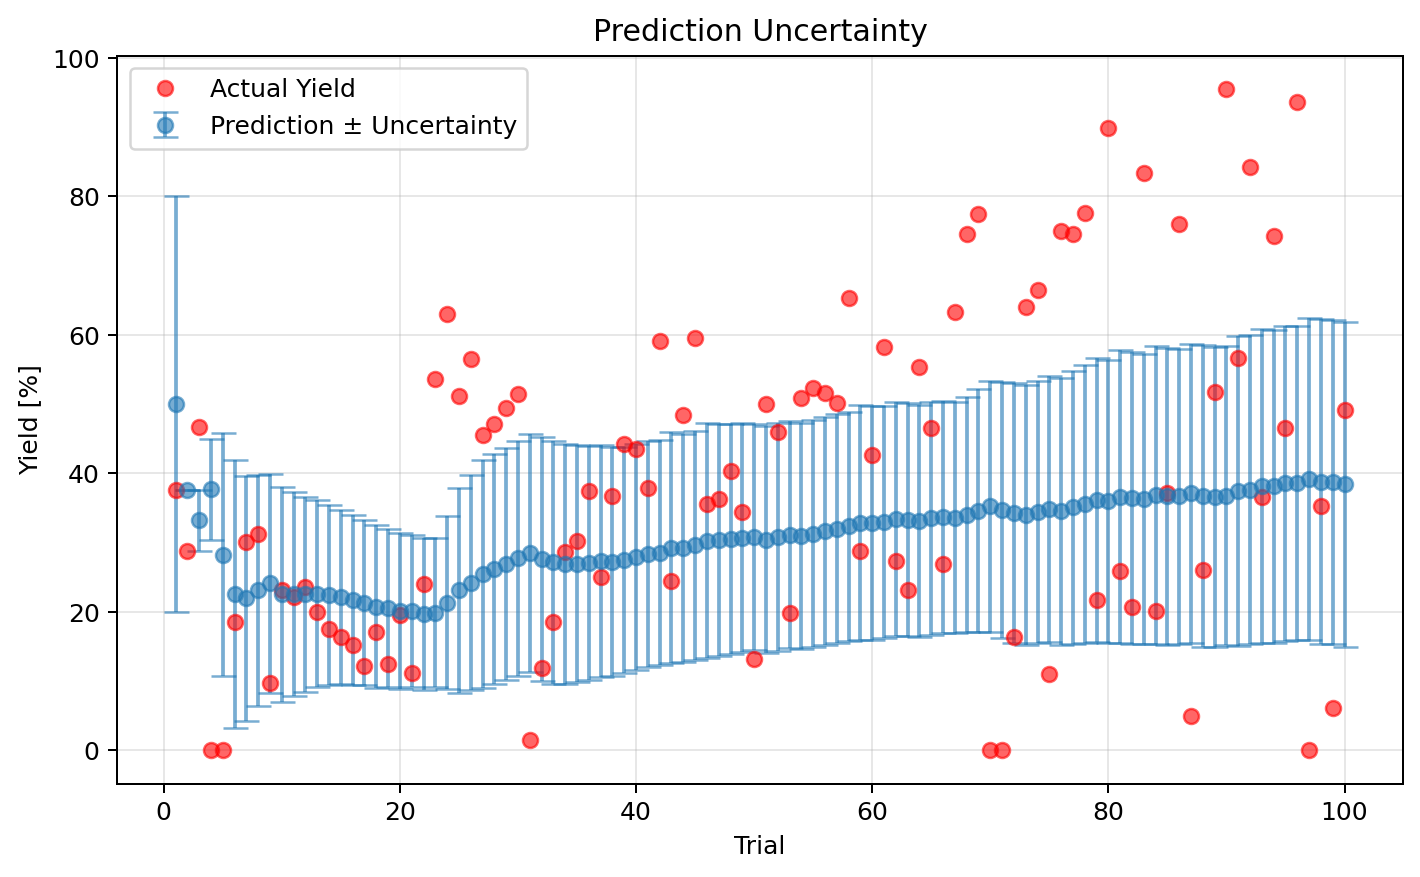


### Error Trend


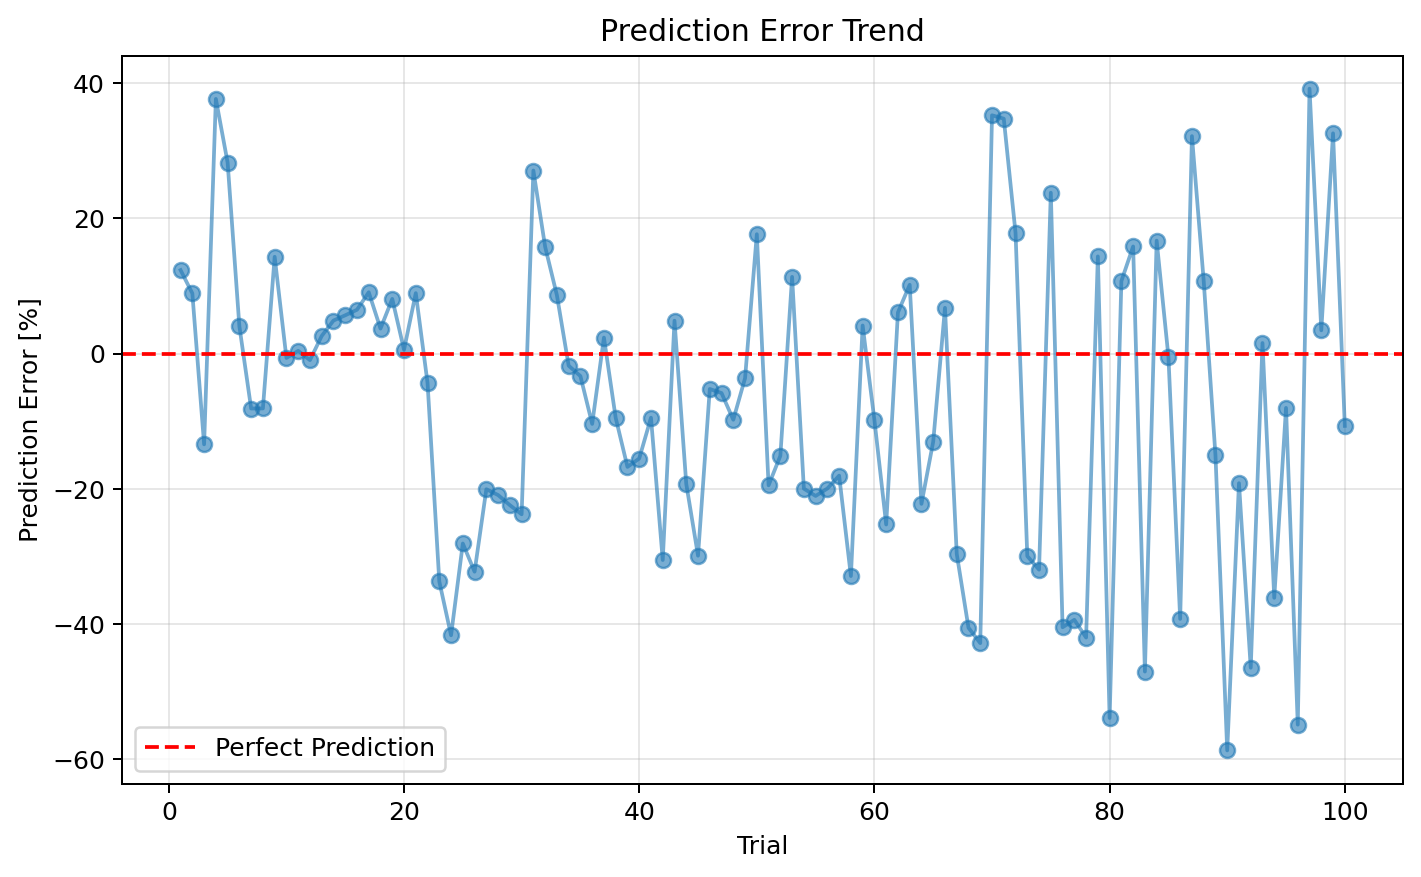


### Error Distribution


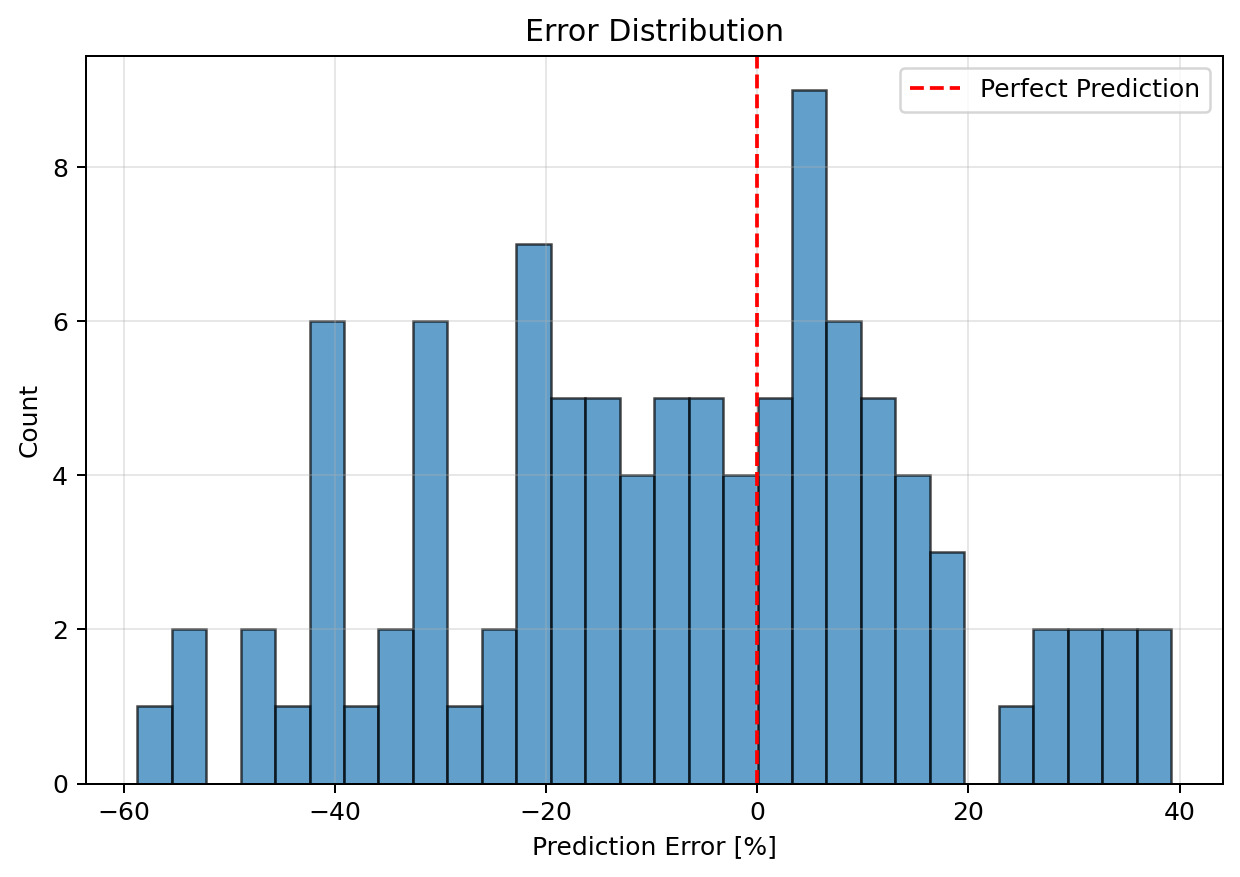


### Uncertainty vs Actual Yield


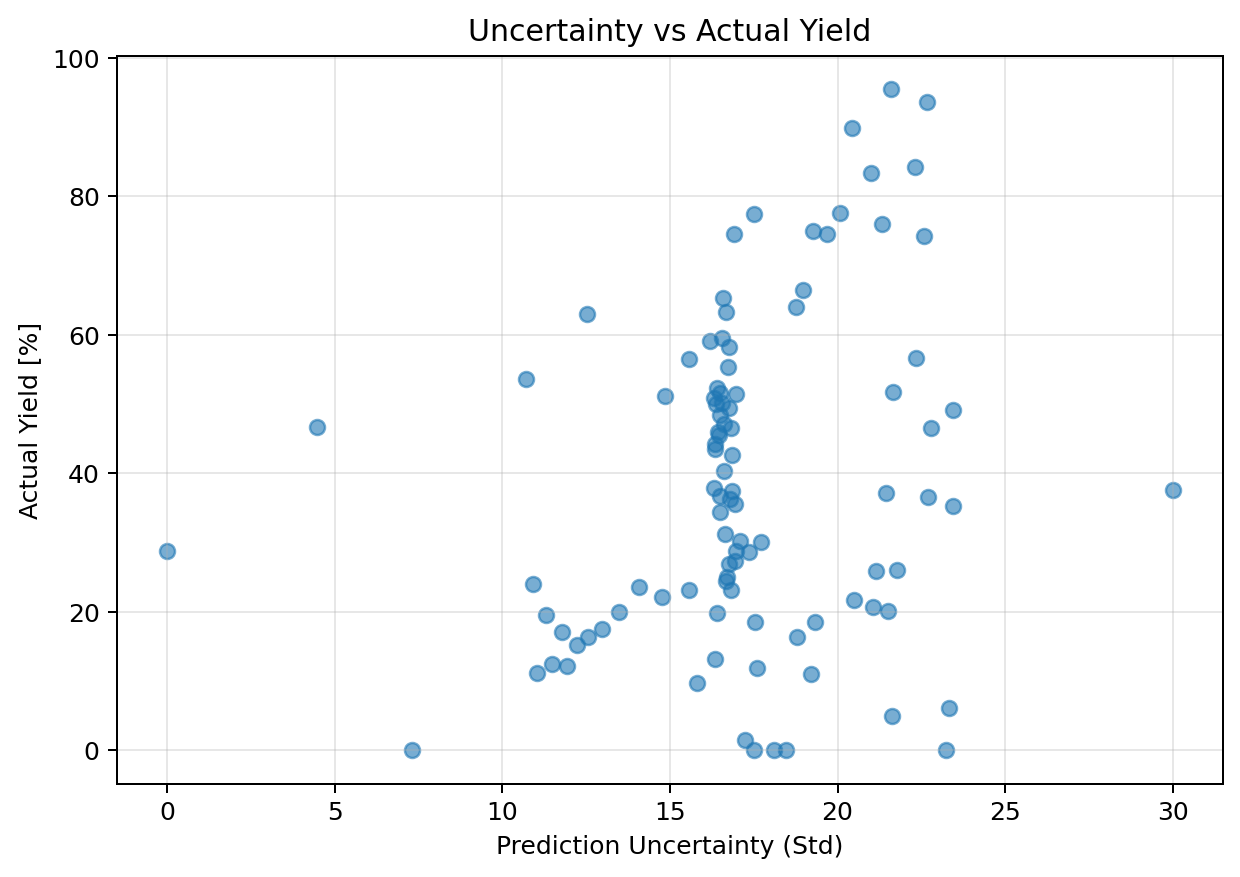

In [15]:
# ‰øùÂ≠ò„Åï„Çå„ÅüÂèØË¶ñÂåñ„ÇíË°®Á§∫
from IPython.display import Image, display

save_dir = os.path.join(gp_optimizer.output_dir, "visualization")

if os.path.exists(save_dir):
    plot_files = [
        ('optimization_progress.png', 'Optimization Progress'),
        ('parity.png', 'Parity Plot'),
        ('uncertainty.png', 'Prediction Uncertainty'),
        ('error_trend.png', 'Error Trend'),
        ('error_hist.png', 'Error Distribution'),
        ('uncertainty_vs_yield.png', 'Uncertainty vs Actual Yield')
    ]
    
    for filename, title in plot_files:
        filepath = os.path.join(save_dir, filename)
        if os.path.exists(filepath):
            print(f"\n### {title}")
            display(Image(filename=filepath))
else:
    print("ÂèØË¶ñÂåñ„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì„ÄÇ")